In this notebook, we will look into reading advanced baseline imager (ABI) data from the GOES-R series of geostationary earth observing satellites. These satellites orbit over a specific point on the Earth's surface, so provide a fixed fireld of view with frequent imagery. The data is provided as NetCDF files, so we can read it using xarray directly

In [1]:
import pathlib
from datetime import datetime
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [16]:
data_path = pathlib.Path("../../data_samples")
print("Storing data locally")

data_path = data_path / "satellite" / "goes"
if not data_path.exists():
    data_path.mkdir(parents=True)

date = datetime(2020,8,1,19,0)

Storing data locally


Note that this data has been coarsened by a factor of 10 to make it easier to handle. If you want to have a look at the full resolution data, you can download some from AWS using the code below, but beware, it's a lot more resource intensive to work with!

In [17]:
# # Set parameters for the data that we want
# bucket_name = "noaa-goes16" # Get data for GOES-16, positioned over 
# product_name = "ABI-L2-MCMIPF" # ABI level 2 multi-channel cloud and moisture imagery product (MCMIP) full disc (F)

# # Initialize s3fs
# import s3fs
# fs = s3fs.S3FileSystem(anon=True)

# # Find ABI files for a particular hour using glob
# prefix = f'{bucket_name}/{product_name}/{date.strftime("%Y/%j/%H")}/OR_{product_name}*_s{date.strftime("%Y%j%H%M")}*.nc'
# keys = fs.glob(prefix)
# print(f'Searching for files that match: {prefix}')
# print(f'Found {len(keys)} files')

# if not list(data_path.glob(f'{prefix.split("/")[-1]}')):
#     print("Downloading file...")
#     fs.download(keys[0], data_path)
# abi_filenames = sorted(list(data_path.glob(f'{prefix.split("/")[-1]}')))
# print(abi_filenames)

From the extension, you can see this is a NetCDF file which can then be read using xarray

In [4]:
ds = xr.open_dataset(
    data_path / "OR_ABI-L2-MCMIPF-M6_G16_s20202141900188_e20202141909501_c20202141909590_coarse.nc"
)

In [5]:
ds

<xarray.Dataset> Size: 38MB
Dimensions:                                 (y: 542, x: 542,
                                             number_of_time_bounds: 2,
                                             number_of_image_bounds: 2, band: 1)
Coordinates: (12/37)
    t                                       datetime64[ns] 8B ...
  * y                                       (y) float32 2kB 0.1516 ... -0.1513
  * x                                       (x) float32 2kB -0.1516 ... 0.1513
    y_image                                 float32 4B ...
    x_image                                 float32 4B ...
    band_wavelength_C01                     (band) float32 4B ...
    ...                                      ...
    band_id_C11                             (band) int8 1B ...
    band_id_C12                             (band) int8 1B ...
    band_id_C13                             (band) int8 1B ...
    band_id_C14                             (band) int8 1B ...
    band_id_C15                             (band) int8 1B ...
    band_id_C16                             (band) int8 1B ...
Dimensions without coordinates: number_of_time_bounds, number_of_image_bounds,
                                band
Data variables: (12/124)
    CMI_C01                                 (y, x) float32 1MB ...
    DQF_C01                                 (y, x) float32 1MB ...
    CMI_C02                                 (y, x) float32 1MB ...
    DQF_C02                                 (y, x) float32 1MB ...
    CMI_C03                                 (y, x) float32 1MB ...
    DQF_C03                                 (y, x) float32 1MB ...
    ...                                      ...
    mean_brightness_temperature_C16         float32 4B ...
    std_dev_brightness_temperature_C16      float32 4B ...
    percent_uncorrectable_GRB_errors        float32 4B ...
    percent_uncorrectable_L0_errors         float32 4B ...
    dynamic_algorithm_input_data_container  int32 4B ...
    algorithm_product_version_container     int32 4B ...
Attributes: (12/29)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    ...                        ...
    date_created:              2020-08-01T19:09:59.0Z
    time_coverage_start:       2020-08-01T19:00:18.8Z
    time_coverage_end:         2020-08-01T19:09:50.1Z
    timeline_id:               ABI Mode 6
    production_data_source:    Realtime
    id:                        fb825602-79a0-4d3a-b427-48bc202a6c3a

The `NetCDF` file format is not designed to be read directly from the cloud, unlike more modern formats such as `zarr`. There are ways to work around this, such as using fsspec or kerchunk. But for most use cases it is easier to download them locally

# Analysing geostationary satellite data from GOES-16

The dataset contains information from each of the 16 visible, near-IR and IR channels from ABI.

The visible/near-IR channels measure reflected sunlight, and these are recorded as reflectance values between 0 and 1, as shown below

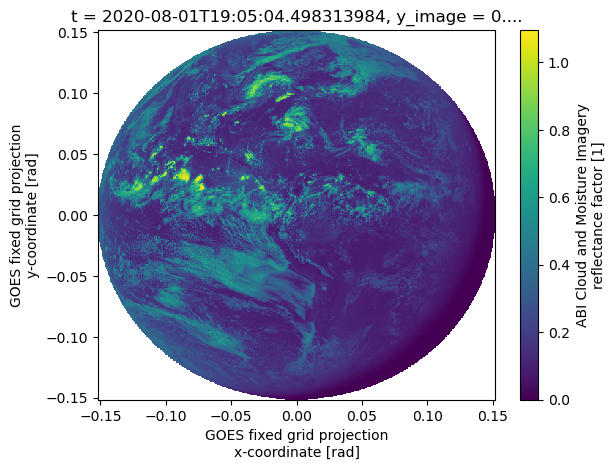

In [6]:
ds.CMI_C01.plot()

The IR channels measure emitted thermal radiation recorded as brightness temperature, approximating the blackbody temperature (in Kelvin) that would result in the observed radiance

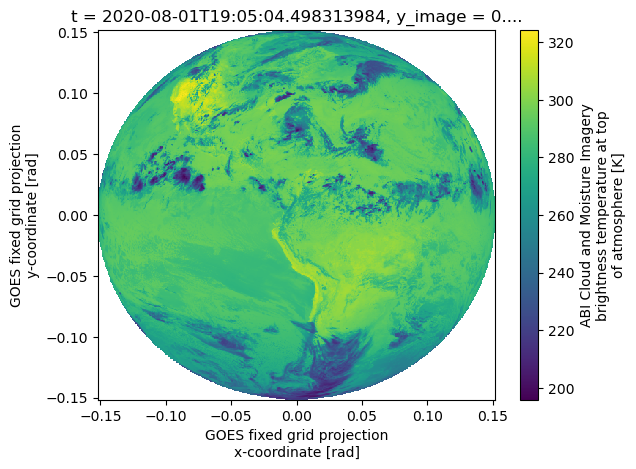

In [7]:
ds.CMI_C13.plot()

Different wavelengths of light tell us different things about the atmosphere: whereas clouds are bright in visible channels due to reflected sunlight, high clouds are dark in brightness temperature as they are much colder than the surface below. In addition, it should be immediately apparent that half of the visible image is in darkness as it is night-time, whereas brightness temperature can be measured day or night.

ABI has 16 channels in total, 6 of which sense reflected solar radiation, 9 which detect emitted IR radiation and 1 which has a combination of both. These are shown below:

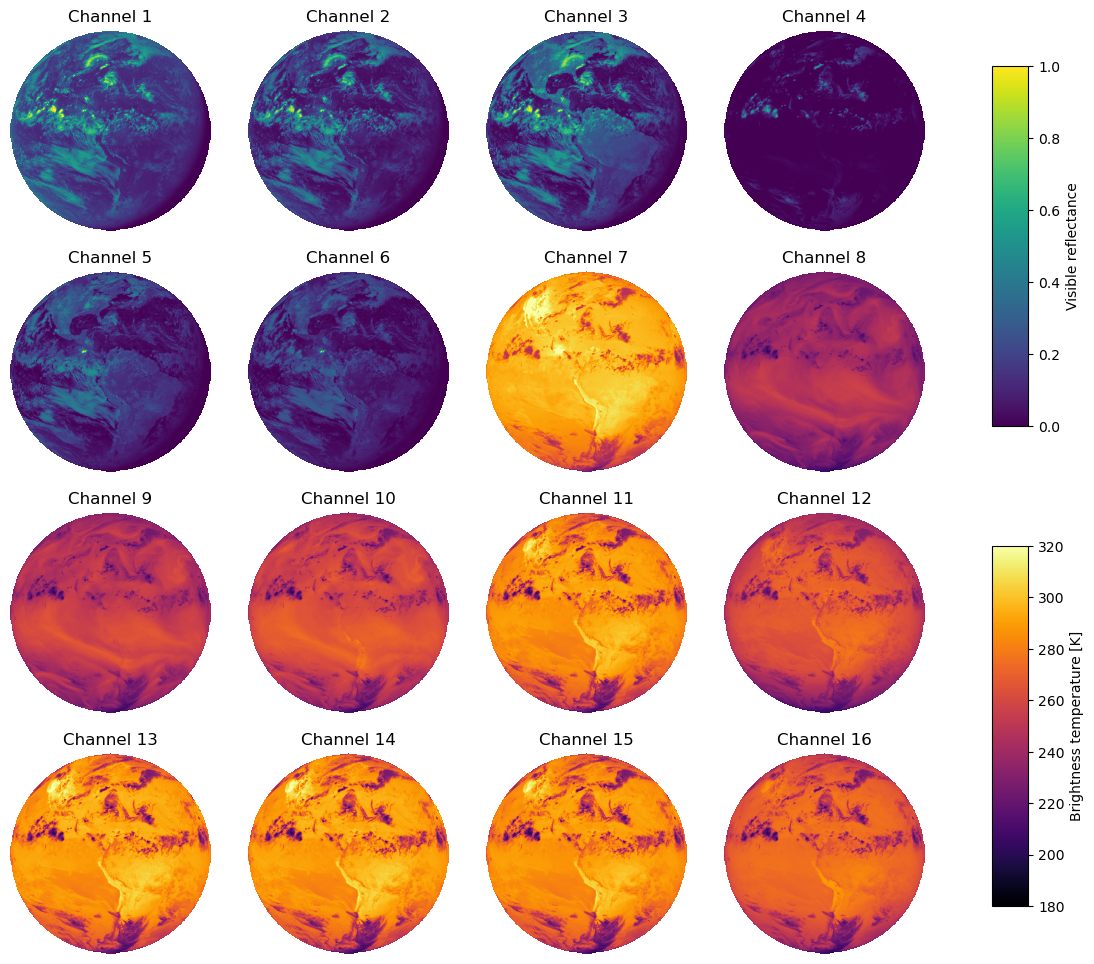

In [8]:
fig, axes = plt.subplots(4,4,sharex=True, sharey=True, figsize=(12,12))
for i in range(16):
    ax = axes[i//4, i%4]
    ax.imshow(
        ds[f'CMI_C{i+1:02d}'], 
        cmap = "viridis" if i<6 else "inferno", 
        vmin = 0 if i<6 else 180, 
        vmax = 1 if i<6 else 320
    )
    ax.set_axis_off()
    ax.set_title(f'Channel {i+1}')

plt.subplots_adjust(hspace=0.2, wspace=0.1)

plt.colorbar(axes[0,0].get_children()[0], cax=fig.add_axes([0.95,0.55,0.03,0.3]), label="Visible reflectance", orientation="vertical")
plt.colorbar(axes[3,3].get_children()[0], cax=fig.add_axes([0.95,0.15,0.03,0.3]), label="Brightness temperature [K]", orientation="vertical")

You can find more about the different channels and what they can detect here: http://cimss.ssec.wisc.edu/goes/GOESR_QuickGuides.html

What channels might provide useful information for different areas of research?

When working with satellite data, we need to be careful about data quality. Instrument errors, specular reflection and other issues can cause some pixels or entire chunks of images to have degraded quality, or be completely missing. The ABI files have a set of data quality flag (DQF) variables, one for each pixel, that tell you the status of each channel:

In [9]:
ds.DQF_C01

<xarray.DataArray 'DQF_C01' (y: 542, x: 542)> Size: 1MB
[293764 values with dtype=float32]
Coordinates:
    t        datetime64[ns] 8B ...
  * y        (y) float32 2kB 0.1516 0.1511 0.1504 ... -0.1502 -0.1508 -0.1513
  * x        (x) float32 2kB -0.1516 -0.1511 -0.1504 ... 0.1502 0.1508 0.1513
    y_image  float32 4B ...
    x_image  float32 4B ...
Attributes: (12/13)
    long_name:                                              ABI Cloud and Moi...
    standard_name:                                          status_flag
    valid_range:                                            [0 4]
    units:                                                  1
    grid_mapping:                                           goes_imager_proje...
    flag_values:                                            [0 1 2 3 4]
    ...                                                     ...
    number_of_qf_values:                                    5
    percent_good_pixel_qf:                                  0.9989618
    percent_conditionally_usable_pixel_qf:                  1e-07
    percent_out_of_range_pixel_qf:                          0.0010269
    percent_no_value_pixel_qf:                              1.12e-05
    percent_focal_plane_temperature_threshold_exceeded_qf:  0.0

The dataset attributes provide information about what these values mean:

In [10]:
qf_dict = dict(zip(ds.DQF_C01.flag_values, ds.DQF_C01.flag_meanings.split(" ")))
print(qf_dict)

{0: 'good_pixel_qf', 1: 'conditionally_usable_pixel_qf', 2: 'out_of_range_pixel_qf', 3: 'no_value_pixel_qf', 4: 'focal_plane_temperature_threshold_exceeded_qf'}


When we apply the DQF mask to the image we can see that the range of reflectances is reduced to 0 to 1

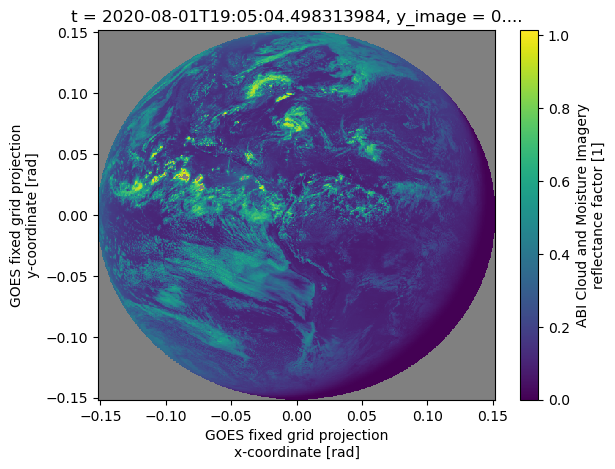

In [11]:
ds.CMI_C01.where(ds.DQF_C01==0).plot()
plt.gca().set_facecolor("grey") # Set the background to grey to see the missing data more clearly

While channels on their own tell us something about the atmosphere, by combining them we can learn a lot more. This is the basis of how retrieval algorithms work. Here, instead of make quantitative calculations about the atmosphere, we will instead create some False colour RGB images which we can qualitatively interpret

We'll start my making a "True" colour image, similar to what we would see if we were orbiting the Earth with GOES-16. However, the ABI instrument doesn't have a green channel! Instead, we can use the 0.86 um channel in the near-IR, which is very sensitive to vegitation, to simulate a green channel

A gamma factor modifies the range of values to look more like what our eyes would see

In [12]:
def true_colour_rgb(ds):
    """A 'True' colour RGB combination from GOES-16 ABI"""
    gamma = 0.4

    R = ds.CMI_C02.where(ds.DQF_C02<=0) # channel 2, at 0.67um, senses red light
    G = ds.CMI_C03.where(ds.DQF_C03<=0) # channel 3, at 0.86um, is very sensitive to vegetation
    B = ds.CMI_C01.where(ds.DQF_C01<=0) # channel 1, at 0.46um, senses blue light
    
    G = 0.45 * R + 0.1 * G + 0.45 * B # To make it look like visible green, we combine it with the red and blue channels
    
    RGB = xr.concat([R, G, B], "channel").transpose("y", "x", "channel")
    RGB = RGB**gamma # raise everything by the gamma value
    RGB = np.clip(RGB, 0, 1) # limit to the range 0->1
    return RGB

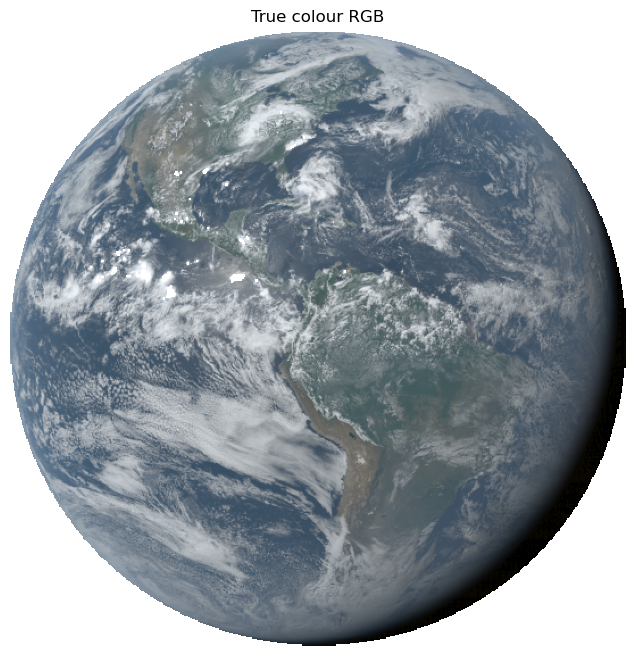

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
ax.imshow(true_colour_rgb(ds))
ax.set_title("True colour RGB")
ax.set_axis_off()

The image appears murky because of absorbtion in the atmosphere, but we can see North and South America distinctly from the surrounding oceans. There are also a lot of clouds!

We can also use other combinations, including thermal IR channels, to tell us more about the surface and atmosphere

The next exercise is to create a different RGB combination, using thermal IR channels. This RGB uses the difference between channels to tell us something about the properties of observed clouds. Try creating an image using the following recipe:

 - Red: Channel 15 - channel 13. Range of -6.7K to 2.6K
 - Green: Channel 13 - channel 7. Range of -3.1K to 5.2K
 - Blue: Channel 13 only. Range of 244K to 294K

This combination uses a gamma value of 1, and is based on https://rammb2.cira.colostate.edu/wp-content/uploads/2020/01/QuickGuide_GOESR_NtMicroRGB_Final_20191206-1.pdf

In [14]:
def false_colour_rgb(ds):
    """A false colour RGB combination from GOES-16 ABI showing cloud properties at night"""
    gamma = 1

    R = (ds.CMI_C15.where(ds.DQF_C15<=0) - ds.CMI_C13.where(ds.DQF_C13<=0)) # channel 15 - channel 13, between -6.7K and 2.6K
    R = (R - -6.7) / (2.6 - -6.7) # Rescale to between 0 and 1 by subtracting the lower value, then dividing by the difference between the lower and upper limit

    G = (... - ...) # channel 13 - channel 7, between -3.1K and 5.2K
    G = (G - ...) / (... - ...)
    
    B = ... # channel 13, between 244K and 294K
    B = (B - ...) / (... - ...)
     
    RGB = xr.concat([R, G, B], "channel").transpose("y", "x", "channel")
    RGB = RGB**gamma # raise everything by the gamma value
    RGB = np.clip(RGB, 0, 1) # limit to the range 0->1
    return RGB

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
ax.imshow(false_colour_rgb(ds))
ax.set_title("Cloud microphysics RGB")
ax.set_axis_off()

This image shows us something very different to what we would see with our own eyes, but tells us much more about clouds that the "True" colour image before. Thick, high altitude clouds show in red, while clear sky is shown as blue. Low, warm clouds show as light blue or turqouise, and cold, low clouds near the South pole show as yellow. These kind of composites are useful for weather forecasters who need to quickly see how clouds are changing, but for research we need something more scientific...

# Analysing satellite retrievals from Aqua MODIS

For scientific purposes, what we want are quantitive values that tell us something about what we are observing. These are provided using retrievals: inverse models that estimate what the state of the object we were observing

In this part of the workshop, we will look at retrievals from the moderate resolution imaging spectroradiometer (MODIS). MODIS instruments have flown on the Aqua and Terra satellites, and have collected a huge amount of data on the atmosphere, oceans and land surface over a 20 year period. They are probably some of the most used scientific data from satellites.

Unfortunately, MODIS data is provided as HDF files, which are much harder to read than NetCDF. Rather than try and read them ourselves, we can use another python library called Satpy, which is designed for working with satellite data

In [14]:
# Find MODIS files on JASMIN:
modis_data_path = pathlib.Path("/neodc/modis/data/") # TODO: update to iedct gws
if modis_data_path.exists():
    print("Storing data on JASMIN")
    modis_data_path = modis_data_path / "MYD06_L2" / "collection61" / date.strftime("%Y/%m/%d")
else:
    modis_data_path = pathlib.Path("../../data_samples/satellite/modis")
    print("Storing data locally")


Storing data locally


In [18]:
modis_file = list(modis_data_path.glob(f'MYD06_L2.A{date.strftime("%Y%j")}.1900.*hdf'))[0]
print(modis_file)

../../data_samples/satellite/modis/MYD06_L2.A2020214.1900.061.2020215153855.hdf


The data model for satpy is a "Scene" which consists of one or multiple satellite images. A scene can be created using one of the many readers built in to satpy: https://satpy.readthedocs.io/en/stable/reading.html

In [19]:
from satpy import Scene
modis_scn = Scene(filenames=[str(modis_file)], reader="modis_l2") # read one file using the modis level 2 reader

By default, satpy won't load any data straight away. Instead, we need to load the specific variables we are interested in

In [20]:
# List all available variables
modis_scn.available_dataset_names()

['above_cloud_water_vapor_094',
 'brightness_temperature',
 'cirrus_reflectance',
 'cirrus_reflectance_flag',
 'cloud_effective_emissivity',
 'cloud_effective_emissivity_day',
 'cloud_effective_emissivity_nadir',
 'cloud_effective_emissivity_nadir_day',
 'cloud_effective_emissivity_nadir_night',
 'cloud_effective_emissivity_night',
 'cloud_effective_radius',
 'cloud_effective_radius_16',
 'cloud_effective_radius_1621',
 'cloud_effective_radius_1621_pcl',
 'cloud_effective_radius_16_PCL',
 'cloud_effective_radius_37',
 'cloud_effective_radius_37_PCL',
 'cloud_effective_radius_pcl',
 'cloud_effective_radius_uncertainty',
 'cloud_effective_radius_uncertainty_16',
 'cloud_effective_radius_uncertainty_1621',
 'cloud_effective_radius_uncertainty_37',
 'cloud_emiss11',
 'cloud_emiss12',
 'cloud_emiss13',
 'cloud_emiss85',
 'cloud_emissivity',
 'cloud_fraction',
 'cloud_fraction_day',
 'cloud_fraction_nadir',
 'cloud_fraction_nadir_day',
 'cloud_fraction_nadir_night',
 'cloud_fraction_night',


In [21]:
# Load cloud water path
modis_scn.load(["cloud_water_path"])

Underneath the satpy scene, the data that's just been loaded is stored as an xarray dataset. We can access the dataset to see what it looks like...

In [22]:
modis_scn.to_xarray()

<xarray.Dataset> Size: 33MB
Dimensions:           (y: 2030, x: 1354)
Coordinates:
    longitude         (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    latitude          (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
Dimensions without coordinates: y, x
Data variables:
    cloud_water_path  (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
Attributes:
    history:      Created by pytroll/satpy on 2025-10-22 09:32:53.384880
    Conventions:  CF-1.7

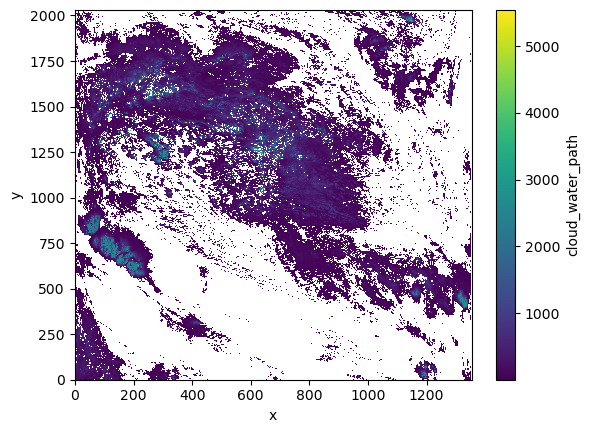

In [23]:
modis_scn.to_xarray().cloud_water_path.plot()

Cloud water path is a measure of the mass of condensed water (in g) for each 1 m^2 column of atmoshere. The centres of clouds tend to have much higher values than the thinner edges.

Note the missing data, showing clear sky areas where no cloud properties are retrieved

Exercise: Load the "cloud_top_height" data and plot it. How does it compare the the cloud water path?

In [ ]:
modis_scn.load(...)

In [25]:
modis_scn.to_xarray()

<xarray.Dataset> Size: 44MB
Dimensions:           (y: 2030, x: 1354)
Coordinates:
    longitude         (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    latitude          (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
Dimensions without coordinates: y, x
Data variables:
    cloud_top_height  (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    cloud_water_path  (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
Attributes:
    history:      Created by pytroll/satpy on 2025-10-22 09:34:59.307629
    Conventions:  CF-1.7

In the previous two plots, the image looks like a regular square grid. However, the combination of the satellite orbit and the sensor field of view means that the area on the ground is nowhere near as regular. We can plot how this area looks using matplotlib and cartopy.

Text(0.5, 1.0, 'Modis cloud top height')

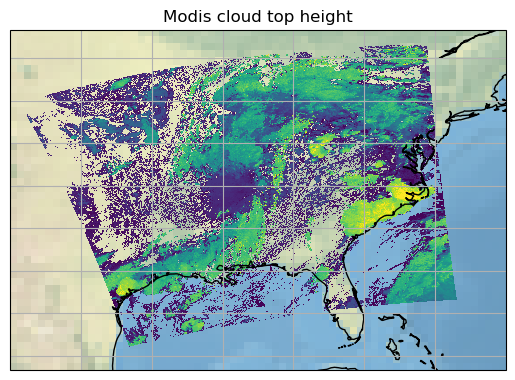

In [26]:
import cartopy.crs as ccrs
fig, ax = plt.subplots(1,1, subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.stock_img()
ax.coastlines()
ax.gridlines()
modis_ds = modis_scn.to_xarray()
ax.pcolormesh(modis_ds.longitude, modis_ds.latitude, modis_ds.cloud_top_height)
ax.set_extent([-70, -105, 23, 47], ccrs.PlateCarree())
ax.set_title(f'Modis cloud top height')


Plotting the data on a map reveals that the geolocated data is slanted (due to the inclination of the satellite orbit) and curved (due to the interaction between the swath width and the projection). This is not very easy to relate to other datasets such as reanalysis data on a regular lat/lon grid.

On of the simplest ways to address this is to resample the data onto a more convenient grid. Satpy has a built in capability to do this:

In [27]:
# Regrid to a global 0.1x0.1 degree grid, using nearest regridding method (the default)
regridded_scn = modis_scn.resample("EPSG_4326_3600x1800", resampler="nearest")

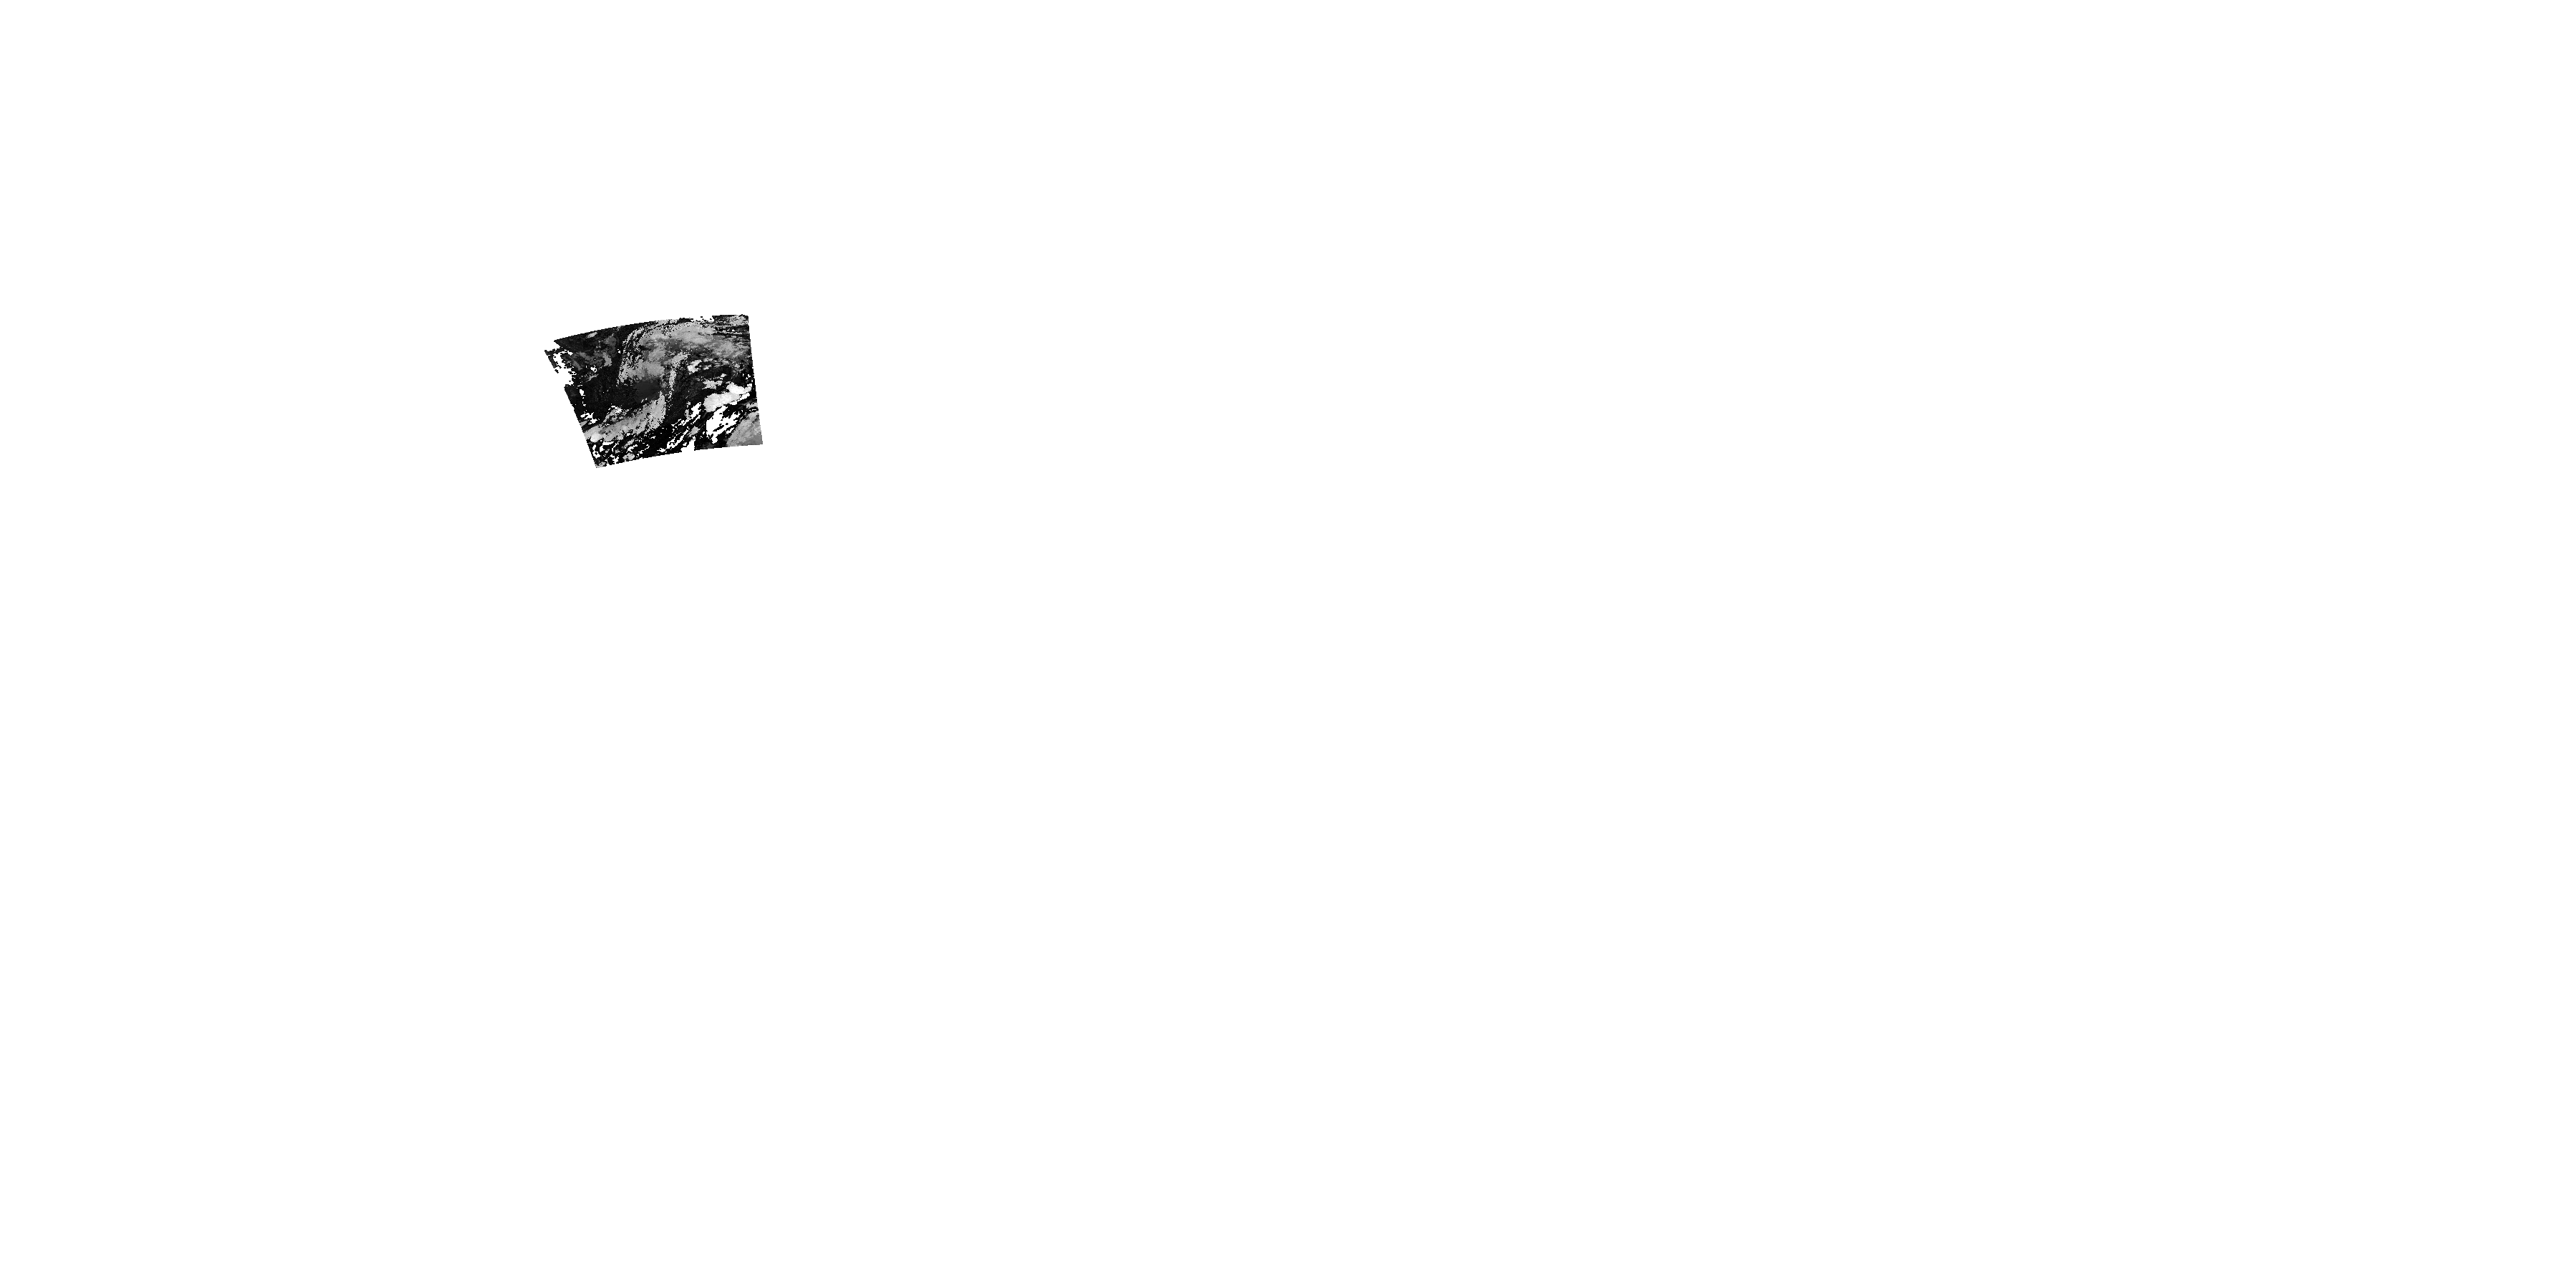

In [66]:
regridded_scn.show("cloud_top_height")

In [67]:
regridded_scn.to_xarray()

<xarray.Dataset> Size: 156MB
Dimensions:              (y: 1800, x: 3600)
Coordinates:
  * y                    (y) float64 14kB 89.95 89.85 89.75 ... -89.85 -89.95
  * x                    (x) float64 29kB -179.9 -179.8 -179.8 ... 179.9 180.0
    longitude            (y, x) float64 52MB dask.array<chunksize=(1800, 3600), meta=np.ndarray>
    latitude             (y, x) float64 52MB dask.array<chunksize=(1800, 3600), meta=np.ndarray>
Data variables:
    EPSG_4326_3600x1800  int64 8B 0
    cloud_top_height     (y, x) float32 26MB dask.array<chunksize=(1800, 3600), meta=np.ndarray>
    cloud_water_path     (y, x) float32 26MB dask.array<chunksize=(1800, 3600), meta=np.ndarray>
Attributes:
    history:      Created by pytroll/satpy on 2025-10-21 09:01:02.214189
    Conventions:  CF-1.7

The regridded scene is now on a regular grid, similar to a level 3 product. This makes it much simpler to compare to other data. However, the resolution is a lot coarser (0.1 degree compared to the 1km of MODIS).

Exercise: using the following link https://satpy.readthedocs.io/en/stable/resample.html#area-definitions-included-in-satpy find a different grid definition that covers North America at a resolution closer to the original satellite image. Regrid the data using this grid, and plot the result

In [ ]:
regridded_scn = modis_scn.resample(...)

In [ ]:
regridded_scn.show(...)

Traditionally, a lot of work has been done with level 3 satellite data on a regular grid. However, for more detailed work, including training ML models on the level 1 data, we may want to work on the satellite image grid directly. In the next section, we will look closer at how to geolocate satellite observations and combine them with other datasets.

# Projections and geolocation

Working on the native satellite image grid means working out exactly where each pixel corresponds to. Fortunately we have a range of tools available to help with that.

The ABI dataset has coordinates x and y, which represent the scan angle (in radians) of the instrument when it measured each pixel

In [28]:
ds.x

<xarray.DataArray 'x' (x: 542)> Size: 2kB
array([-0.151564, -0.15106 , -0.150444, ...,  0.15022 ,  0.15078 ,  0.15134 ],
      dtype=float32)
Coordinates:
    t        datetime64[ns] 8B ...
  * x        (x) float32 2kB -0.1516 -0.1511 -0.1504 ... 0.1502 0.1508 0.1513
    y_image  float32 4B ...
    x_image  float32 4B ...
Attributes:
    units:          rad
    axis:           X
    long_name:      GOES fixed grid projection x-coordinate
    standard_name:  projection_x_coordinate

In [29]:
ds.y

<xarray.DataArray 'y' (y: 542)> Size: 2kB
array([ 0.151564,  0.15106 ,  0.150444, ..., -0.15022 , -0.15078 , -0.15134 ],
      dtype=float32)
Coordinates:
    t        datetime64[ns] 8B ...
  * y        (y) float32 2kB 0.1516 0.1511 0.1504 ... -0.1502 -0.1508 -0.1513
    y_image  float32 4B ...
    x_image  float32 4B ...
Attributes:
    units:          rad
    axis:           Y
    long_name:      GOES fixed grid projection y-coordinate
    standard_name:  projection_y_coordinate

The ABI instrument scans in rows from left to right, top to bottom, as shown in the video below. This is common for most geostationary satellites, except the Meteosat first and second generation which do the opposite...

In [31]:
%%HTML
<iframe width="560" height="315" src="https://www.youtube.com/embed/qCAPwgQR13w?si=uMa5dNfDTavcZfkD&amp;start=16" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" referrerpolicy="strict-origin-when-cross-origin" allowfullscreen></iframe>

While the ABI images are in Cartesian x/y coordinates, there location on the ground is not a regularly spaced grid. As a result, we need to convert between sensor angles and latitude/longitude to find specific locations and compare different measurements. We can do this using the `pyproj` library, which wraps the `Proj4` software providing projection transformations.

Information about the ABI field of view is contained in the `goes_imager_projection` variable

In [32]:
ds.goes_imager_projection

<xarray.DataArray 'goes_imager_projection' ()> Size: 4B
[1 values with dtype=int32]
Coordinates:
    t        datetime64[ns] 8B ...
    y_image  float32 4B ...
    x_image  float32 4B ...
Attributes:
    long_name:                       GOES-R ABI fixed grid projection
    grid_mapping_name:               geostationary
    perspective_point_height:        35786023.0
    semi_major_axis:                 6378137.0
    semi_minor_axis:                 6356752.31414
    inverse_flattening:              298.2572221
    latitude_of_projection_origin:   0.0
    longitude_of_projection_origin:  -75.0
    sweep_angle_axis:                x

The `pyproj` package wraps around a larger library, called `Proj4`, which contains tools for projecting coordinates into different frames of reference. We can use the `goes_imager_projection` information to create a `Proj` instance that covers the ABI field of view

(Proj is also what cartopy uses internally to handle projections and coordinate transforms, it's a very powerful library!)

In [33]:
from pyproj import Proj

In [34]:
# Create a geostationary projection ("geos") using the parameters from the goes imager projection
goes16_projection = Proj(
    proj="geos", 
    h=ds.goes_imager_projection.perspective_point_height,
    lon_0=ds.goes_imager_projection.longitude_of_projection_origin,
    lat_0=ds.goes_imager_projection.latitude_of_projection_origin,
    sweep=ds.goes_imager_projection.sweep_angle_axis,
)

In [35]:
goes16_projection

<Other Coordinate Operation Transformer: geos>
Description: PROJ-based coordinate operation
Area of Use:
- undefined

We can then use this projection to convert between latitude/longitude and x/y coordinates. Note that the geostationary projection provides x/y in units of metres from the origin, so to convert to radians we divide by the height

In [36]:
h = ds.goes_imager_projection.perspective_point_height
x, y = goes16_projection(-75, 0) / h # This should provide the coordinates [0,0] as the origin point
print(x, y)

0.0 0.0


We can now use these to index the dataset to find a point at a specific longitude and latitude

In [37]:
x, y = goes16_projection(-75, 0) / h
ds.sel(x=x, y=y, method="nearest")

<xarray.Dataset> Size: 684B
Dimensions:                                 (number_of_time_bounds: 2,
                                             number_of_image_bounds: 2, band: 1)
Coordinates: (12/37)
    t                                       datetime64[ns] 8B ...
    y                                       float32 4B -0.00014
    x                                       float32 4B 0.00014
    y_image                                 float32 4B ...
    x_image                                 float32 4B ...
    band_wavelength_C01                     (band) float32 4B ...
    ...                                      ...
    band_id_C11                             (band) int8 1B ...
    band_id_C12                             (band) int8 1B ...
    band_id_C13                             (band) int8 1B ...
    band_id_C14                             (band) int8 1B ...
    band_id_C15                             (band) int8 1B ...
    band_id_C16                             (band) int8 1B ...
Dimensions without coordinates: number_of_time_bounds, number_of_image_bounds,
                                band
Data variables: (12/124)
    CMI_C01                                 float32 4B 0.0946
    DQF_C01                                 float32 4B 0.0
    CMI_C02                                 float32 4B 0.04952
    DQF_C02                                 float32 4B 0.0
    CMI_C03                                 float32 4B 0.2492
    DQF_C03                                 float32 4B 0.0
    ...                                      ...
    mean_brightness_temperature_C16         float32 4B ...
    std_dev_brightness_temperature_C16      float32 4B ...
    percent_uncorrectable_GRB_errors        float32 4B ...
    percent_uncorrectable_L0_errors         float32 4B ...
    dynamic_algorithm_input_data_container  int32 4B ...
    algorithm_product_version_container     int32 4B ...
Attributes: (12/29)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    ...                        ...
    date_created:              2020-08-01T19:09:59.0Z
    time_coverage_start:       2020-08-01T19:00:18.8Z
    time_coverage_end:         2020-08-01T19:09:50.1Z
    timeline_id:               ABI Mode 6
    production_data_source:    Realtime
    id:                        fb825602-79a0-4d3a-b427-48bc202a6c3a

#### Exercise: 

try picking the coordinates of a landmark (e.g. New York), find the GOES-16 coordinates for it and index the nearest pixels in the image. Can you select and plot a region around the place you can chosen?

Hint: channel 3 shows land and sea differences clearly. Remember that the y coordinate goes from positive to negative!

In [50]:
lat, lon = ..., ...


The `pyproj` projection also allows us to convert the other way, from x/y to longitude/latitude:

In [38]:
lon, lat = goes16_projection(0 * h, 0 * h, inverse=True)
print(lon, lat)

-75.0 0.0


We can pass arrays of x/y or lon/lat values into the projection, allowing us to find the latitude and longitude of all ABI pixels:

In [39]:
longitude, latitude = goes16_projection(
    *np.meshgrid(ds.x.data * h, ds.y.data * h), 
    inverse=True
)

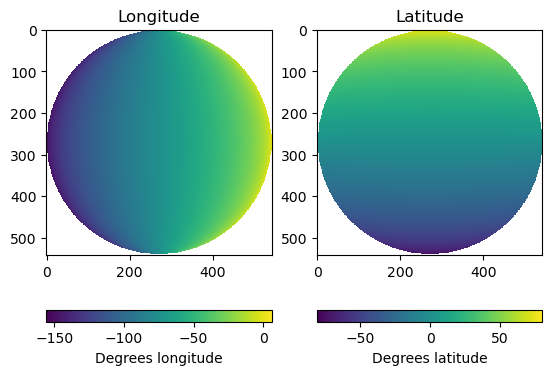

In [40]:
fig, axes = plt.subplots(1,2)
lon_img = axes[0].imshow(longitude)
axes[0].set_title("Longitude")
plt.colorbar(lon_img, ax=axes[0], orientation="horizontal", label="Degrees longitude")
lat_img = axes[1].imshow(latitude)
axes[1].set_title("Latitude")
plt.colorbar(lat_img, ax=axes[1], orientation="horizontal", label="Degrees latitude")


We can then add these arrays to the dataset to provide geolocation coordinates

In [41]:
ds = ds.assign_coords(
    dict(
        longitude = xr.DataArray(longitude, dict(y=ds.y, x=ds.x), dims=("y","x")), 
        latitude = xr.DataArray(latitude, dict(y=ds.y, x=ds.x), dims=("y","x")), 
    )
)

In [42]:
ds

<xarray.Dataset> Size: 42MB
Dimensions:                                 (y: 542, x: 542,
                                             number_of_time_bounds: 2,
                                             number_of_image_bounds: 2, band: 1)
Coordinates: (12/39)
    t                                       datetime64[ns] 8B ...
  * y                                       (y) float32 2kB 0.1516 ... -0.1513
  * x                                       (x) float32 2kB -0.1516 ... 0.1513
    y_image                                 float32 4B ...
    x_image                                 float32 4B ...
    band_wavelength_C01                     (band) float32 4B ...
    ...                                      ...
    band_id_C13                             (band) int8 1B ...
    band_id_C14                             (band) int8 1B ...
    band_id_C15                             (band) int8 1B ...
    band_id_C16                             (band) int8 1B ...
    longitude                               (y, x) float64 2MB inf inf ... inf
    latitude                                (y, x) float64 2MB inf inf ... inf
Dimensions without coordinates: number_of_time_bounds, number_of_image_bounds,
                                band
Data variables: (12/124)
    CMI_C01                                 (y, x) float32 1MB nan nan ... nan
    DQF_C01                                 (y, x) float32 1MB nan nan ... nan
    CMI_C02                                 (y, x) float32 1MB nan nan ... nan
    DQF_C02                                 (y, x) float32 1MB nan nan ... nan
    CMI_C03                                 (y, x) float32 1MB nan nan ... nan
    DQF_C03                                 (y, x) float32 1MB nan nan ... nan
    ...                                      ...
    mean_brightness_temperature_C16         float32 4B ...
    std_dev_brightness_temperature_C16      float32 4B ...
    percent_uncorrectable_GRB_errors        float32 4B ...
    percent_uncorrectable_L0_errors         float32 4B ...
    dynamic_algorithm_input_data_container  int32 4B ...
    algorithm_product_version_container     int32 4B ...
Attributes: (12/29)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    ...                        ...
    date_created:              2020-08-01T19:09:59.0Z
    time_coverage_start:       2020-08-01T19:00:18.8Z
    time_coverage_end:         2020-08-01T19:09:50.1Z
    timeline_id:               ABI Mode 6
    production_data_source:    Realtime
    id:                        fb825602-79a0-4d3a-b427-48bc202a6c3a

We can even use the rgb functions we created earlier, and the new latitude and longitude coordinates will remain as part of the dataset:

In [43]:
rgb = true_colour_rgb(ds)
rgb

<xarray.DataArray 'CMI_C02' (y: 542, x: 542, channel: 3)> Size: 4MB
array([[[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       [[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       [[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       [[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       [[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]]], dtype=float32)
Coordinates:
    t          datetime64[ns] 8B 2020-08-01T19:05:04.498313984
  * y          (y) float32 2kB 0.1516 0.1511 0.1504 ... -0.1502 -0.1508 -0.1513
  * x          (x) float32 2kB -0.1516 -0.1511 -0.1504 ... 0.1502 0.1508 0.1513
    y_image    float32 4B 0.0
    x_image    float32 4B 0.0
    longitude  (y, x) float64 2MB inf inf inf inf inf ... inf inf inf inf inf
    latitude   (y, x) float64 2MB inf inf inf inf inf ... inf inf inf inf inf
Dimensions without coordinates: channel

We can't index using these new coordinates directly, but we can mask the image using them to select a region:

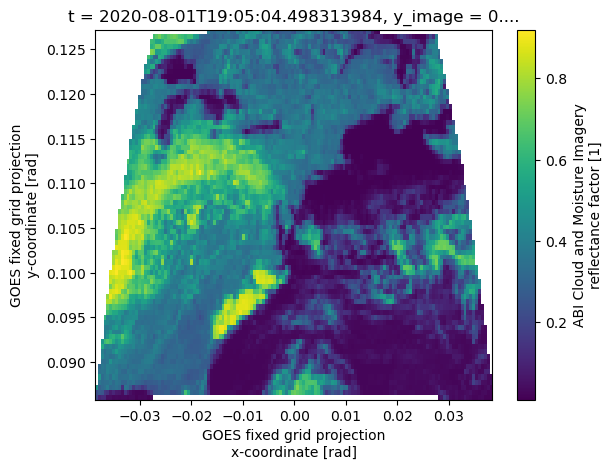

In [44]:
ds.CMI_C03.where(
    (ds.latitude>30) & (ds.latitude<50) & (ds.longitude>-90) & (ds.longitude<-60), 
    drop=True
).plot()

#### Exercise:
Try selecting different regions. How does the image become distorted towards the edge of the satellite field of view?

The `rioxarray` package extends `xarray` in a similar manner to how `geopandas` extends `pandas`. We don't have time to cover it today, but it offers a lot of very useful functionality for geolocating many datasets

# Colocation

We have looked at how to geolocate one satellite dataset, but what happens if we want to combine different satellite data from different perspectives? Matching observations in time and space is called colocation. We can use these technioques not only for satellite data, but also to compare ground stations, trajectories, model output and many more.

Let's start simply by plotting the ABI imagery and MODIS cloud properties on top of each other

Text(0.5, 1.0, 'ABI RGB and Modis cloud top height')

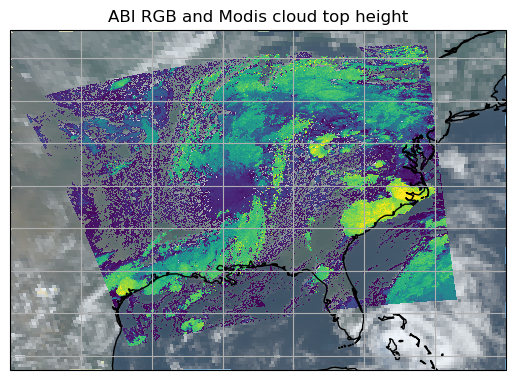

In [45]:
fig, ax = plt.subplots(1,1, subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.stock_img()
ax.coastlines()
ax.gridlines()

# Make a subset of the GOES RGB data:
rgb_subset = rgb.where(
    (rgb.latitude>23) & (rgb.latitude<47) & (rgb.longitude>-105) & (rgb.longitude<-70), 
    drop=True
)
ax.pcolormesh(rgb_subset.longitude, rgb_subset.latitude, rgb_subset)

# Plot MODIS over the top:
ax.pcolormesh(modis_ds.longitude, modis_ds.latitude, modis_ds.cloud_top_height)
ax.set_extent([-70, -105, 23, 47], ccrs.PlateCarree())
ax.set_title(f'ABI RGB and Modis cloud top height')


We can show how the locations of the ABI and MODIS images are related, but they aren't yet on the same grid, so we can't compare their values directly.

Next, let's use the goes image proejction to find the nearest points in the ABI image for each MODIS pixel

The MODIS data also has "x" and "y" coordinates. These are the cross-track and along-track dimensions respectively, corresponding to the direction of the satellite's orbit. Unlike GOES ABI, MODIS is aboard a polar orbiting satellite, so the exact location of each pixel is unique for every file!

#### Exercise: 
Find the x/y ABI coordinates for each pixel in the MODIS image from their longitude and latitude. Then, use these to create a new xarray dataset from ABI that matches the shape and position of the MODIS data

Hint: to select data in `xarray` using multidimensional arrays they must be `xarray` DataArrays with mathcing coordinates. Try copying the MODIS longitude and latitude and replacing their values with the x and y locations you would like to select.

Remember to divide the output from `goes16_projection` by `h` to convert to radians!

In [ ]:
modis_x, modis_y = ...

In [ ]:
colocated_abi_ds = ds.sel(...)

In [ ]:
colocated_abi_ds

In [ ]:
# Now plot side by side
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=(12,5))

axes[0].pcolormesh(modis_ds.longitude, modis_ds.latitude, modis_ds.cloud_top_height)
axes[0].set_extent([-70, -105, 23, 47], ccrs.PlateCarree())
axes[0].set_title(f'Modis cloud top height')
axes[0].coastlines()
axes[0].gridlines()

axes[1].pcolormesh(colocated_abi_ds.longitude, colocated_abi_ds.latitude, true_colour_rgb(colocated_abi_ds))
axes[1].set_extent([-70, -105, 23, 47], ccrs.PlateCarree())
axes[1].set_title(f'Colocated ABI RGB')
axes[1].coastlines()
axes[1].gridlines()


As the data is now perfectly aligned, we can compare the values directly:

Text(0.5, 1.0, 'Comparing cloud top height and BT')

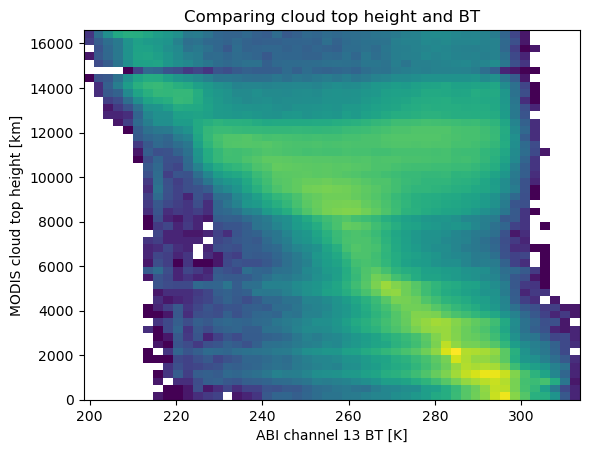

In [58]:
where_finite = np.isfinite(modis_ds.cloud_top_height)
plt.hist2d(colocated_abi_ds.CMI_C13.values[where_finite], modis_ds.cloud_top_height.values[where_finite], bins=50, norm="log")
plt.xlabel("ABI channel 13 BT [K]")
plt.ylabel("MODIS cloud top height [km]")
plt.title("Comparing cloud top height and BT")

We can see how in general higher cloud tops correspond to colder observed BT, but for thinner clouds the BT can remain near surface levels.

#### Extension task
Compare other MODIS cloud properties to different channels of GOES-16 ABI. Which channels change most depending on the different properties?